#Point-E - Point-E: A System for Generating 3D Point Clouds from Complex Prompts.


This is the official code and model release for Point-E: A System for Generating 3D Point Clouds from Complex Prompts. 

Original OpenAI github link: https://github.com/openai/point-e

Colab created and adapted by George Guida. Feb. 2023

# Setup

In [ ]:
!nvidia-smi

Sat Mar 25 13:57:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/gdrive')

# Create directory path
dir_path = "/content/gdrive/MyDrive/AI/point-e"

# Check if directory already exists
if not os.path.exists(dir_path):
    # Create directory if it doesn't exist
    os.makedirs(dir_path)
    print(f"Directory '{dir_path}' created successfully.")
else:
    print(f"Directory '{dir_path}' already exists.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Directory '/content/gdrive/MyDrive/AI/point-e' already exists.


In [ ]:
# Set repository URL
repo_url = "https://github.com/openai/point-e.git"

# Set repository folder name
repo_folder = "point-e-main"

# Set repository path
repo_path = os.path.join(dir_path, repo_folder)

# Check if repository already exists
if not os.path.exists(repo_path):
    # Clone repository if it doesn't exist
    print(f"Cloning repository from {repo_url}...")
    !git clone {repo_url} {repo_path}
    print(f"Repository cloned to {repo_path}.")
else:
    print(f"Repository already exists in {repo_path}.")

# Change working directory to repository directory
os.chdir(repo_path)
print(f"Changed working directory to {repo_path}.")

Repository already exists in /content/gdrive/MyDrive/AI/point-e/point-e-main.
Changed working directory to /content/gdrive/MyDrive/AI/point-e/point-e-main.


In [ ]:
!pip install -e .
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/gdrive/MyDrive/AI/point-e/point-e-main
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-16uqodt2/clip_c5c260a170d34fe7b7a5aa78dad8f7dd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-16uqodt2/clip_c5c260a170d34fe7b7a5aa78dad8f7dd
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Attempting uninstall: point-e
    Found existing installation: point-e 0.0.0
    Can't uninstall 'point-e'. No files were found to uninstall.
  Running setup.py develop for point-e
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import skimage.measure
skimage.measure.label

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.diffusion.sampler import PointCloud
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud
from point_e.util.pc_to_mesh import marching_cubes_mesh

In [ ]:
#Model setup and checkpoint downloads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

#Parameters

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [ ]:
#@markdown ####**Insert a prompt:**
Prompt_text = "a blue chair, highly detailed" #@param{type: 'string'}

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[Prompt_text]))):
    samples = x

0it [00:00, ?it/s]

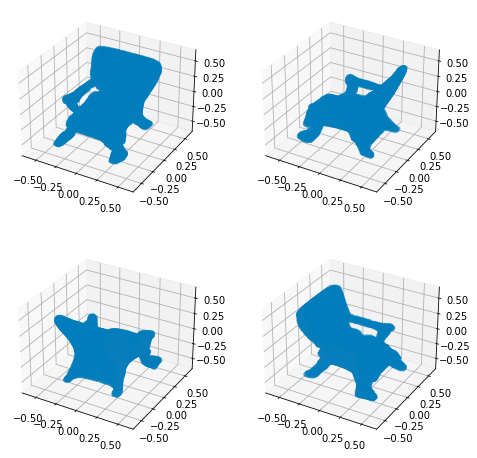

In [ ]:
#time to plot!
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.65, -0.65, -0.65),(0.65, 0.65, 0.65)))

#Export Point Cloud or Mesh

###Export Point Cloud to google drive as a point cloud

In [ ]:
# Running the method using LeRes
#@markdown **Point Cloud name**
Export_ptCloud_name = "Point-e-cloud-07" #@param {type:"string"}
Output_Folder_path = "/content/gdrive/MyDrive/AI/point-e/point-e-main/Output/" #@param {type:"string"}

Output_file_name = Output_Folder_path + Export_ptCloud_name + ".xyz"
print("The xyz point cloud will be saved as", Output_file_name)

Output_file_name_ply = Output_Folder_path + Export_ptCloud_name + ".ply"
print("The ply point cloud will be saved as", Output_file_name_ply)

The xyz point cloud will be saved as /content/gdrive/MyDrive/AI/point-e/point-e-main/Output/Point-e-cloud-06.xyz
The ply point cloud will be saved as /content/gdrive/MyDrive/AI/point-e/point-e-main/Output/Point-e-cloud-06.ply


In [ ]:
#this saves the file as a .xyz coordinate file
import numpy as np
rgb_scale = 255
xyz = np.concatenate([pc.coords, 
                      rgb_scale * np.array([pc.channels["R"], 
                                            pc.channels["G"], 
                                            pc.channels["B"]
                                           ]
                                          ).T
                     ], axis=1)
np.savetxt(Output_file_name, xyz)
print("File Saved here: " + Output_file_name)

File Saved here: /content/gdrive/MyDrive/AI/point-e/point-e-main/Output/Point-e-cloud-06.xyz


In [ ]:
# this saves the point cloud as a ply file
import numpy as np
import open3d as o3d

# points = np.loadtxt("/content/gdrive/MyDrive/AI/point-e/point-e-main/Output/test3.xyz", skiprows=0)
points = np.loadtxt(Output_file_name, skiprows=0)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[:, :3]) # Extract only the 3D coordinates
pcd.colors = o3d.utility.Vector3dVector(points[:, 3:] / 255) # Extract RGB colors and normalize to range [0, 1]

# o3d.io.write_point_cloud("/content/your_file.ply", pcd)
o3d.io.write_point_cloud(Output_file_name_ply, pcd)
print('Success!')

Success!


### Export point Cloud as a .ply locally

In [ ]:
Export_file_locally_on_runAll = True #@param {type: 'boolean'}

if Export_file_locally_on_runAll == True:
    from google.colab import files
    files.download(Output_Folder_path + Export_ptCloud_name + ".ply")
    print('File will be exported locally! Uncheck if you do now want to download this from g.drive')
else:
  print('To export locally, press the button and re-run the cell')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File will be exported locally! Uncheck if you do now want to download this from g.drive


##Export Geomerty as a ply or obj

###Setup

In [ ]:
# Running the method using LeRes
#@markdown **Mesh file name**
Export_mesh_name = "Point-E_mesh_04" #@param {type:"string"}

Output_mesh_file_name = Output_Folder_path + Export_mesh_name + ".npz"
print("The file will be saved as ", Output_mesh_file_name)

In [ ]:
# Create subfolder called "Output" if it doesn't exist
output_path = os.path.join(repo_path, "Output")
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Directory '{output_path}' created successfully.")
else:
    print(f"Directory '{output_path}' already exists.")

print("Make sure to change the file name for the next cell so you dont replace the previous file!")

In [ ]:
PointCloud.save(pc, Output_mesh_file_name)
print('done!')

In [ ]:
import numpy as np
pc = sampler.output_to_point_clouds(samples)[0] 
np.savez_compressed(Output_mesh_file_name, coords=pc.coords, **pc.channels)

### SDF Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

In [ ]:
# Load a point cloud we want to convert into a mesh.
pc = PointCloud.load(Output_mesh_file_name)
# pc = PointCloud.load('/content/gdrive/MyDrive/AI/point-e/point-e-main/Output/pointcloud_02.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(pc, grid_size=1)

In [ ]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

In [ ]:
output_file_name_ply = f"{Output_Folder_path}{Export_mesh_name}.ply"
print(output_file_name_ply)
# Write mesh data to PLY file
with open(output_file_name_ply, 'wb') as f:
    mesh.write_ply(f)

###Save obj + glb to google drive output folder

Keep in mind, reconstructing the point cloud in grasshopper or houdini etc, can at times produce better quality surfaces than the obj and glb outputs. 

In [ ]:
skip_export_for_run_all = False #@param {type: 'boolean'}

if skip_export_for_run_all == True:
    print('Skipping obj creation, uncheck skip_export_for_run_all if you want to run it')
else:
  !pip install trimesh
  import trimesh

In [ ]:
output_file_name_obj = f"{Output_Folder_path}{Export_mesh_name}.obj"
output_file_name_glb = f"{Output_Folder_path}{Export_mesh_name}.glb"

mesh = trimesh.load(output_file_name_ply)
# mesh.export(output_file_name_glb)
mesh.export(output_file_name_obj)
print('done')

###Exporting files locally

In [ ]:
# Select the preferred format

Export_PLY_file_Locally = True #@param {type: 'boolean'}
Export_OBJ_file_Locally = True #@param {type: 'boolean'}

if Export_PLY_file_Locally == True:
    files.download(output_file_name_ply)
if Export_OBJ_file_Locally == True:
    files.download(output_file_name_obj)
